In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Step 1: Load the Data
file_path = r'C:/Users/techin/Oil_price_Time_series_Analysis/data/BrentOilPrices.xlsx'
df = pd.read_excel(file_path)

# Ensure proper date formatting and sorting
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

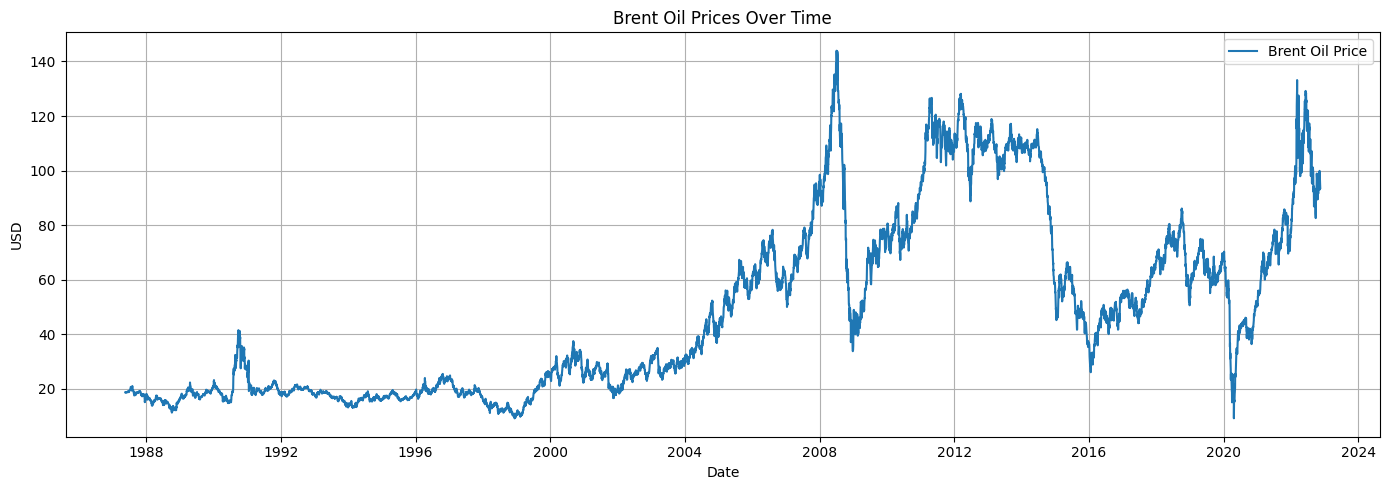

In [4]:
# Plot original price data
plt.figure(figsize=(14, 5))
plt.plot(df['Price'], label='Brent Oil Price')
plt.title('Brent Oil Prices Over Time')
plt.ylabel('USD')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

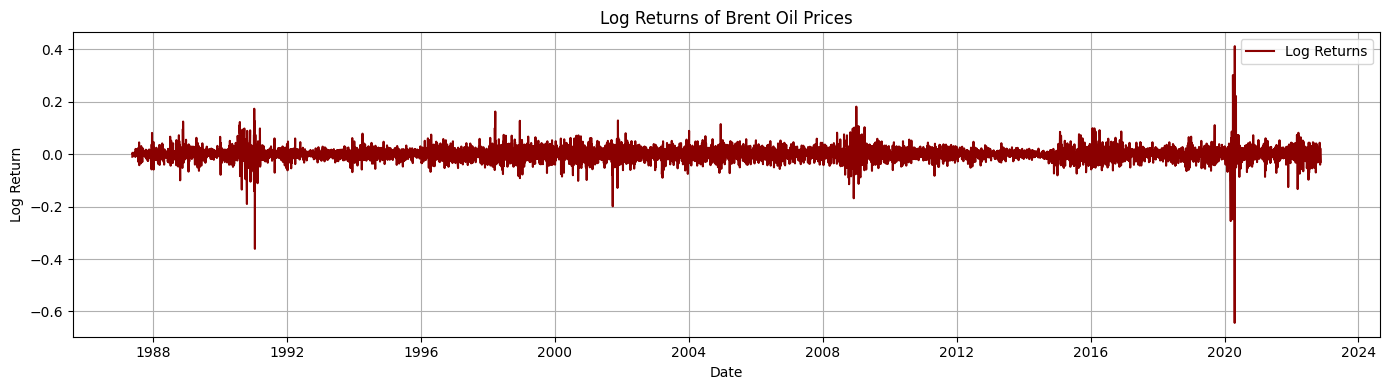

In [5]:
# Step 2: Compute log returns (for stationarity and change detection)
df['LogReturn'] = np.log(df['Price'] / df['Price'].shift(1))
df = df.dropna()

# Plot log returns
plt.figure(figsize=(14, 4))
plt.plot(df['LogReturn'], color='darkred', label='Log Returns')
plt.title('Log Returns of Brent Oil Prices')
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, mu2, mu1]
>Metropolis: [tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 38658 seconds.
The acceptance probability does not match the target. It is 0.8740890451117781, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


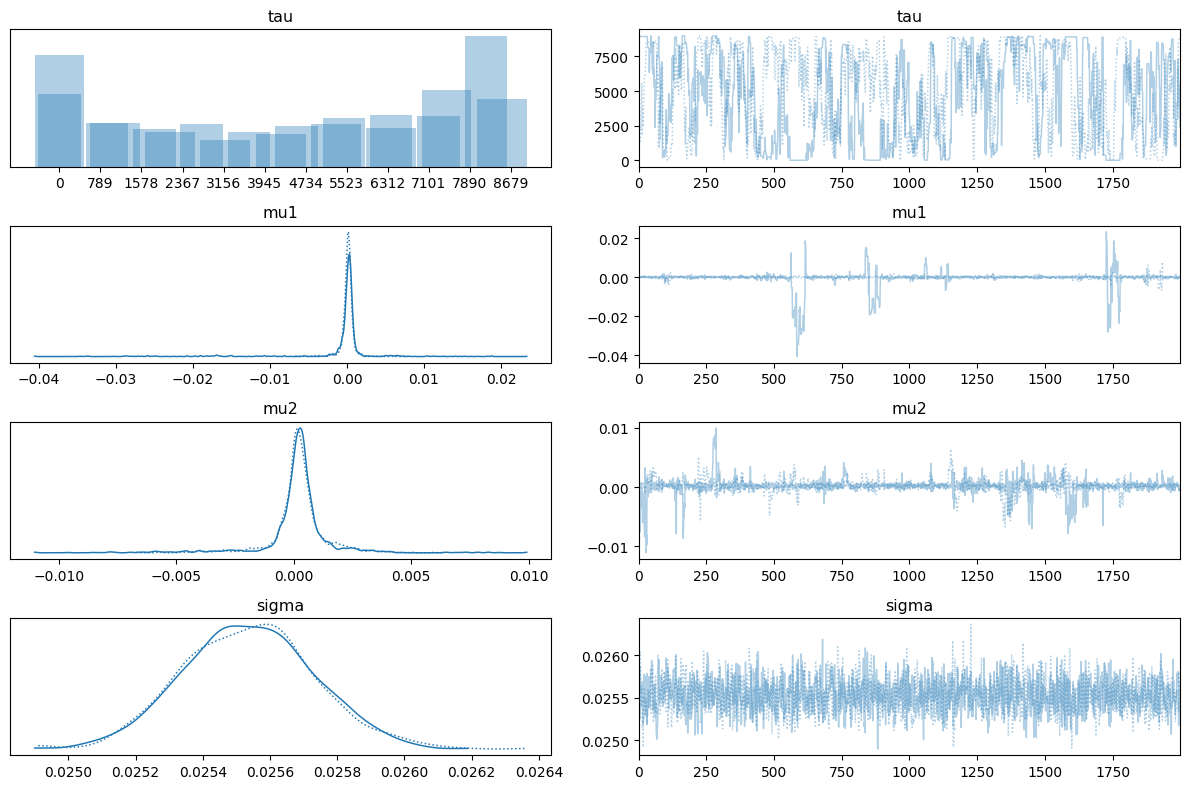

           mean        sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
tau    4849.222  3153.298     0.000   8901.000     342.92  243.322      78.0   
mu1      -0.000     0.004    -0.004      0.003       0.00    0.000     778.0   
mu2       0.000     0.001    -0.002      0.003       0.00    0.000     503.0   
sigma     0.026     0.000     0.025      0.026       0.00    0.000    1755.0   

       ess_tail  r_hat  
tau       103.0   1.02  
mu1       152.0   1.02  
mu2       229.0   1.00  
sigma    1926.0   1.00  

📌 Estimated Change Point (tau): Index 4849, Date: 2006-06-07


In [7]:
log_returns = df['LogReturn'].values
n = len(log_returns)

# Step 3: Bayesian Change Point Modeling
with pm.Model() as model_cp:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)
    returns_obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    # Use NUTS sampler to support `target_accept`
    step = pm.NUTS(target_accept=0.95)
    trace_cp = pm.sample(2000, tune=1000, step=step, return_inferencedata=True)

# Step 4: Traceplot
az.plot_trace(trace_cp)
plt.tight_layout()
plt.show()

# Step 5: Summary
summary = az.summary(trace_cp, hdi_prob=0.95)
print(summary)

# Step 6: Identify change point date
tau_posterior = trace_cp.posterior['tau'].values.flatten()
estimated_tau = int(np.mean(tau_posterior))
change_date = df.index[estimated_tau]
print(f"\n📌 Estimated Change Point (tau): Index {estimated_tau}, Date: {change_date.strftime('%Y-%m-%d')}")

In [10]:
df.columns

Index(['Price', 'LogReturn', 'Estimated_mu'], dtype='object')

In [13]:
import os
import json
import numpy as np
import pandas as pd
import arviz as az

# Ensure output directory exists
os.makedirs("data", exist_ok=True)

# 1. Save change point info
tau_posterior = trace_cp.posterior['tau'].values.flatten()
estimated_tau = int(np.mean(tau_posterior))
tau_std = float(np.std(tau_posterior))
change_date = df.index[estimated_tau]

change_point_info = {
    "tau_index": estimated_tau,
    "tau_std": tau_std,
    "change_date": change_date.strftime('%Y-%m-%d')
}
with open("data/change_point_info.json", "w") as f:
    json.dump(change_point_info, f, indent=4)

# 2. Save log return regime means
mu1 = trace_cp.posterior['mu1'].mean().values.item()
mu2 = trace_cp.posterior['mu2'].mean().values.item()
df['Estimated_mu'] = np.where(
    np.arange(len(df)) < estimated_tau,
    mu1,
    mu2
)
df[['LogReturn', 'Estimated_mu']].to_csv("data/log_returns_mu.csv", index=True, index_label='Date')

# 3. Save posterior samples of tau
np.save("data/tau_posterior_samples.npy", tau_posterior)

# 4. Save summary statistics
summary_df = az.summary(trace_cp, hdi_prob=0.95)
summary_df.to_csv("data/model_summary.csv")

# 5. Save raw prices
df[['Price']].to_csv("data/brent_prices.csv", index=True, index_label='Date')

print("✅ All model outputs saved to /data/")

✅ All model outputs saved to /data/
